In [1]:
import pandas as pd
from unipath import Path
import os
from datetime import datetime as dt
import pickle
import numpy as np
import time as time
import matplotlib.pyplot as plt
import sys
import math

Import data

In [7]:
dirname = os.path.abspath(os.getcwd())
dirname = Path(dirname).resolve()
parentFolder = dirname.parent
parent3Folder = parentFolder.parent.parent
filepath = os.path.join(parent3Folder,"Data","PJM\\",)
filename = filepath+'PJM_RTO_FuelTypeGen_16-18_Hourly.csv' 
Gen3Y = pd.read_csv(filename)
Gen3Y.columns = ["Date","Fuel","MW","Perc","IsRenew"]
Start = Gen3Y.shape[0]
Gen3Y = Gen3Y.drop_duplicates(["Date","Fuel"])
End = Gen3Y.shape[0]
print(str(Start-End) + " ""{0:.11%}".format((Start-End)/Start))

23 0.00798608338%


Clean into table with all columns and useful date properties

In [8]:
GenShort = Gen3Y.copy()
GenShort = GenShort.drop(["Perc","IsRenew"],axis=1)
GenShort = GenShort.pivot(index="Date", columns="Fuel", values='MW')

In [9]:
GenShort.insert(loc=0,column="Year",value=pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%y %H:%M').year)
GenShort.insert(loc=1,column="Month",value=pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%y %H:%M').month)
GenShort.insert(loc=2,column="Day",value=pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%y %H:%M').day)
GenShort.insert(loc=3,column="Hour",value=pd.to_datetime(GenShort.index.get_level_values(0).values, format='%m/%d/%y %H:%M').hour)
GenShort = GenShort.reset_index(drop=True)
GenShort = GenShort.drop("Flywheel",axis=1)
GenShort["SolWind"] = GenShort.iloc[:,[12,14]].sum(axis=1)
GenShort["RenewInclHyd"] = GenShort.iloc[:,[6,11,12,14]].sum(axis=1)
GenShort["RenewExclHyd"] = GenShort.iloc[:,[11,12,14]].sum(axis=1)
GenShort["Total"] = GenShort.iloc[:,range(4,15)].sum(axis=1)
GenShort["AbsSolWind"] = GenShort["SolWind"] #Copy, to calculate the fines
GenShort["AbsRenewInclHyd"] = GenShort["RenewInclHyd"]
GenShort["AbsRenewExclHyd"] = GenShort["RenewExclHyd"]
GenShort["AbsTotExclSolWind"] = GenShort["Total"]-GenShort["SolWind"]
GenShort["AbsTotExclRenInclHyd"] = GenShort["Total"]-GenShort["RenewInclHyd"]
GenShort["AbsTotExclRenExclHyd"] = GenShort["Total"]-GenShort["RenewExclHyd"]
GenShort.sort_values(["Year","Month","Day","Hour"], inplace=True, ascending=True)  
GenShort = GenShort.reset_index(drop=True)

In [11]:
#pickle.dump(GenShort, open( "GenShort.p", "wb" ))

In [3]:
#GenShort = pickle.load(open("GenShort.p",'rb'))

Descriptive Statistics

In [12]:
DescStats = pd.DataFrame(np.empty(shape=(5,GenShort.shape[1])),columns=GenShort.columns, index=["Min","Mean","Max","Std Dev","Coeff Var"])
DescStats.iloc[0,:] = np.array(GenShort.min())
DescStats.iloc[1,:] = np.array(GenShort.mean())
DescStats.iloc[2,:] = np.array(GenShort.max())
DescStats.iloc[3,:] = np.array(GenShort.std())
DescStats.iloc[4,:] = DescStats.iloc[3,:]/DescStats.iloc[1,:]
DescStats = DescStats.iloc[:,4:19]
DescStats.iloc[0:3,:] = DescStats.iloc[0:3,:].round(0)  
DescStats.iloc[4,:] = DescStats.iloc[4,:].round(2)
DescStats.iloc[0:4,:] = DescStats.iloc[0:4,:].applymap(lambda x: "{0:.0f}".format(x))
DescStats.iloc[4:4,:] = DescStats.iloc[4:4,:].applymap(lambda x: "{0:.2f}".format(x))
print(DescStats)

Fuel        Coal    Gas Hydro Multiple Fuels Nuclear    Oil  Other  \
Min        12024   1649   103              0   15324      0      0   
Mean       28919  24814  1732            774   32454    296    834   
Max        53914  63107  6990           6398   36954  13955  31147   
Std Dev     8183   8753  1428            845    2109    689   4014   
Coeff Var   0.28   0.35  0.82           1.09    0.06   2.33   4.81   

Fuel      Other Renewables Solar Storage  Wind SolWind RenewInclHyd  \
Min                    336     0       0     0       9          871   
Mean                   633   125       0  2227    2351         4716   
Max                    891  1030     142  7666    7670        13320   
Std Dev                 85   196       2  1540    1533         2089   
Coeff Var             0.13  1.57   45.69  0.69    0.65         0.44   

Fuel      RenewExclHyd   Total  
Min                559   60022  
Mean              2984   92807  
Max               8239  154203  
Std Dev           15

Create a graph to visualize Renewable Production

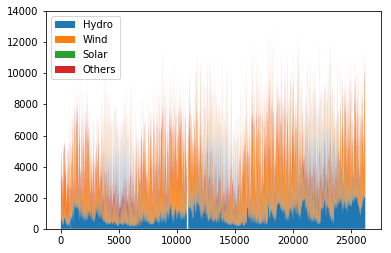

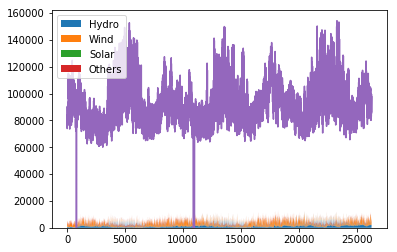

In [8]:
x = GenShort.index
p1 = GenShort["Hydro"]
p2 = GenShort["Wind"]
p3 = GenShort["Solar"]
p4 = GenShort["Other Renewables"]
y = np.vstack([p1,p2,p3,p4])
labels = ["Hydro","Wind","Solar","Others"]
fig, ax = plt.subplots()
ax.stackplot(x,p1,p2,p3,p4,labels=labels)
ax.legend(loc='upper left')
#plt.savefig('Renewable Production.png',dpi=300)
plt.show()

fig, ax = plt.subplots()
labels = ["Hydro","Wind","Solar","Others"]
ax.stackplot(x,p1,p2,p3,p4,labels=labels)
ax.legend(loc='upper left')
ax.plot(GenShort["Total"])

#plt.savefig('Total+Renewable.png',dpi=300)
plt.show()

Create Capacity Utilization

In [9]:
def calc_Util(columnRange,periods):
    
    start_time = time.time()
    columnRange = pd.DataFrame(columnRange)
    numRows = columnRange.shape[0]
    numCols  = columnRange.shape[1]
    outputRange = pd.DataFrame(np.zeros(shape=(columnRange.shape)),columns=columnRange.columns)
    
    for c in range(numCols):
        print(str(c) + "--- %s seconds ---" % (time.time() - start_time))
        
        maxColumn = columnRange.iloc[:,c].rolling(window=periods, center=True).max().fillna(method='bfill').fillna(method='pad')
        for r in range(numRows):
            if maxColumn[r]>0:               
                outputRange.iloc[r,c] = columnRange.iloc[r,c]/maxColumn[r]
            else:
                outputRange.iloc[r,c] = 0 #To avoid division by zero
                
    print("--- %s seconds ---" % (time.time() - start_time))
    
    return outputRange

In [ ]:
GenPerc = GenShort.copy() #Following calculations take about 20 minutes
GenPerc.iloc[:,range(4,18)] = calc_Util(GenShort.iloc[:,range(4,18)],360*24)#All production methods are run with 1/2 year both ways
GenPerc.iloc[:,range(18,19)] = calc_Util(GenShort.iloc[:,range(18,19)],(30*24)) #Peak values are run with only 15 days both ways

In [9]:
#pickle.dump(GenPerc, open( "GenPerc.p", "wb" ))

In [ ]:
#GenPerc = pickle.load(open("GenPerc.p",'rb'))

Create average Utlization

In [ ]:
start_time = time.time() #Takes about 12 minutes to run
GenAvg = GenPerc.drop_duplicates(["Month","Day","Hour"])
for r in range(GenAvg.shape[0]):
    if r%1000 == 0:
        print(str(r) + "--- %s seconds ---" % (time.time() - start_time))
    DummyArray = GenPerc[GenPerc.Day==GenAvg.iloc[r,2]]
    DummyArray = DummyArray[GenPerc.Hour==GenAvg.iloc[r,3]]
    DummyArray = DummyArray[GenPerc.Month==GenAvg.iloc[r,1]]
    GenAvg.iloc[r,:] = DummyArray.mean() 

GenAvg = GenAvg.drop("Year",axis=1)
print("--- %s seconds ---" % (time.time() - start_time))

In [12]:
#pickle.dump(GenAvg, open( "GenAvg.p", "wb" ))

In [109]:
#GenAvg = pickle.load(open("GenAvg.p",'rb'))

In [110]:
#MeritOrderParams = pickle.load(open("MeritOrderParams.p",'rb'))

Now, go and simulate - proliferate and be happy

In [134]:
PeakLimit = 2/3
QueueData = GenAvg.drop(GenAvg.columns[range(0,14)],axis=1)
peakTH = QueueData.Total.quantile(PeakLimit)
renewAvg = [QueueData.SolWind.mean(),QueueData.RenewInclHyd.mean(),QueueData.RenewExclHyd.mean()]
#Create demand rates that are dependent on it being a peak hour or not and average Sup Rate
QueueData["SolWindRate"] = (QueueData.SolWind/renewAvg[0])
QueueData["RenewInclRate"] = (QueueData.RenewInclHyd/renewAvg[1])
QueueData["RenewExclRate"] = (QueueData.RenewExclHyd/renewAvg[2])
QueueData["DemRate"] = (QueueData.Total>=peakTH)*(1/(1-PeakLimit))#Rescale demand during peak time to average 1 unit acros alL periods
#Now merge the penalty function parameters
AvgRates = MeritOrderParams.mean(axis=0)
QueueData["A"] = AvgRates[3]
QueueData["B"] = AvgRates[4]
QueueData["C"] = AvgRates[5]
QueueData["D"] = AvgRates[6]
for i in range(GenAvg.shape[0]):
    try:
        currParams = MeritOrderParams.loc[(MeritOrderParams.Month==GenAvg.Month[i]) & (MeritOrderParams.Day==GenAvg.Day[i]) & (MeritOrderParams.Hour ==GenAvg.Hour[i])]
        QueueData.iloc[i,14:18] = currParams.iloc[0,3:7].values
    except:
        pass

Function to create Rate Matrix of M/M/1 queue given rates and state space

In [37]:
#Function to create RateMatrix
def create_RateMatrix(lamb,mu,States):
    if States == 1:
        return np.eye(1)
    
    RateMatrix = np.eye(States)
    RateMatrix.ravel()[1:max(0,States-1)*States:States+1] = lamb
    RateMatrix.ravel()[States*1:States*(1+States):States+1] = mu
    np.fill_diagonal(RateMatrix,(-(lamb+mu)))
    RateMatrix[0,0]=-lamb
    RateMatrix[(States-1),(States-1)]=-mu
    
    return RateMatrix

In [63]:
def meritFunc(x, a, b, c , d):
    return a*np.exp(x/10000) + b*x**3 + c * x + d

In [155]:
def period_Loss(Pis, currentLamb, AvgAbsLamb, currentMuAbs, currLossParameters):
    #Treat all cases with the state-space being small
    penaltyUnits = 3
    if Pis.shape[0] >= 3:
        penaltyUnits = 3*Pis[0] + 2*Pis[1] + 1*Pis[2]
    elif Pis.shape[0] == 2:
        penaltyUnits = 3*Pis[0] + 2*Pis[1]
    else:
        penaltyUnits = 3
    
    #Deduct current Output
    penaltyUnits -= currentLamb

    #Look where in the Merit order I am an how much it would cost me
    meritOrderPoint = currentMuAbs+penaltyUnits*AvgAbsLamb
    meritOrderPrice = meritFunc(meritOrderPoint, *currLossParameters) #Take highest price to clear market
    totalPenalty = meritOrderPrice * penaltyUnits * AvgAbsLamb
    
    return totalPenalty

In [163]:
def NHPP_Simul(BatterySize ,intervalsPerHour, lambArr, muArr, lambArrAbs, meritArrAbs, approxIter, lossParameters):
    
    #Error Checking at its best
    try:
        if type(BatterySize) != int:
            return print("The BatterySize has to be an integer")
    except:
        return print("Provided the wrong data formate for the Battery Size. Please pass an integer to the function")

    try:
        if  type(intervalsPerHour) != int:
            return print("The intervals per hour have to be an integer")    
    except:
        return print("Provided the wrong data formate for the intervals. Please pass an integer to the function")
    
    try:
        if len(lambArr) != len(muArr)  != len(lambArrAbs) != len(meritArrAbs):
            return print("Supply and Demand rates are not of identical length")
    except:
        return print("Provided the wrong data format for the rates. Please pass columns to the function")
    
    try:
        if  type(approxIter) != int:
            return print("Num of iterations for rate approximation have to be integer values")
    except:
        return print("Provided the wrong data format for the approximation runs. Please pass an integer to the function")
    
    
    #Adjust for the subperiod lengths
    BatterySize += 1 #Battery state spaces are one larger than the battery
    periods = len(lambArr)-1
    subperiods = periods * intervalsPerHour
    
    #Create all arrays needed during calculation
    loss = np.zeros(shape=(1, BatterySize))
    I = np.eye(BatterySize)
    Pis = np.zeros(BatterySize)
    Pis[BatterySize-1] = 1 
    PiZeros = np.zeros(subperiods+1)
    PiZeros[0] = 0 #Initialize at 0 periods with discharged
    AvgLamb = lambArrAbs.mean()
    Loss = 0 #Initialize at 0 periods with 

    #Calculate All Transition Rates
    for subperiod in range(subperiods):
        hour = int(subperiod / intervalsPerHour)
            
        #Check if you need new ratematrix
        if subperiod%intervalsPerHour==0:
            RateMatrix = create_RateMatrix(lambArr[hour], muArr[hour], BatterySize)
            TransPr = np.linalg.matrix_power(I + 0.5 * RateMatrix / intervalsPerHour / approxIter, approxIter)#Continuity Correction
        
        #Multiply new probabilities
        Pis = np.dot(Pis, TransPr)
        
        #Paste loss value
        PiZeros[subperiod+1] = Pis[0] #Check how often battery is out of charge
        Loss += max(0,period_Loss(Pis, lambArr[hour], AvgLamb, meritArrAbs[hour],lossParameters[hour,:]))/intervalsPerHour

        #Calculate second half of period
        Pis = np.dot(Pis, TransPr)

        
    return PiZeros, PiZeros.mean(), Loss

Cycle through different sizes of battery and find percentage at which battery is empty

In [ ]:
UpperLimit = 48
NumYears = 3
BatAt0Avg = np.zeros(shape=(UpperLimit,3))
BatLosses = np.zeros(shape=(UpperLimit,3))
#Simulates this stuff, but for 10 years. #10 Years for 48 Battery Capacity takes about 
start_time = time.time()
for SizeRun in range(0,UpperLimit):
    if SizeRun%1 == 0:
        print(str(SizeRun) + "--- %s seconds ---" % (time.time() - start_time))
    #Run it with Num Years * Observations, iterate over all battery sizes with 10 subperiods per period...
    _ , BatAt0Avg[SizeRun,0], BatLosses[SizeRun,0] = NHPP_Simul(SizeRun, 10, np.tile(QueueData.SolWindRate,NumYears), np.tile(QueueData.DemRate,NumYears), np.tile(QueueData.AbsSolWind,NumYears), np.tile(QueueData.AbsTotExclSolWind,NumYears), 1024, np.tile(QueueData.iloc[:,14:18],(NumYears,1)))
    _ , BatAt0Avg[SizeRun,1], BatLosses[SizeRun,1] = NHPP_Simul(SizeRun, 10, np.tile(QueueData.RenewInclRate,NumYears), np.tile(QueueData.DemRate,NumYears), np.tile(QueueData.AbsRenewInclHyd,NumYears), np.tile(QueueData.AbsTotExclRenInclHyd,NumYears), 1024, np.tile(QueueData.iloc[:,14:18],(NumYears,1)))
    _ , BatAt0Avg[SizeRun,2], BatLosses[SizeRun,2] = NHPP_Simul(SizeRun, 10, np.tile(QueueData.RenewExclRate,NumYears), np.tile(QueueData.DemRate,NumYears), np.tile(QueueData.AbsRenewExclHyd,NumYears), np.tile(QueueData.AbsTotExclRenExclHyd,NumYears), 1024, np.tile(QueueData.iloc[:,14:18],(NumYears,1)))



In [174]:
pickle.dump(BatAt0Avg, open( "BatAt0Avg.p", "wb" ))
pickle.dump(BatLosses, open( "BatLosses.p", "wb" ))

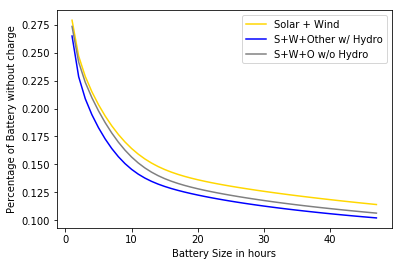

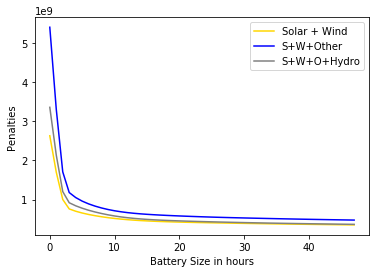

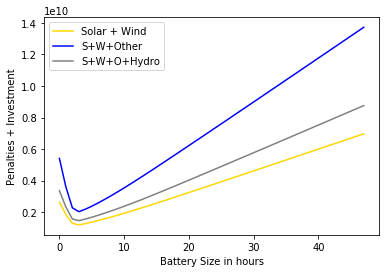

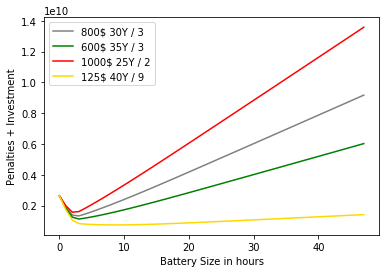

In [208]:
#Plot BatterySize vs outage over time 
startSize = 0
stopSize = 48 #len(BatAt0Avg)
x = [*range(startSize,stopSize)]
y0 = BatAt0Avg[startSize:stopSize,0]
y1 = BatAt0Avg[startSize:stopSize:,1]
y2 = BatAt0Avg[startSize:stopSize:,2]

plt.plot(x,y0, color='Gold')
plt.plot(x,y1, color='Blue')
plt.plot(x,y2, color='Grey')

plt.xlabel("Battery Size in hours")
plt.ylabel("Percentage of Battery without charge")
plt.legend(["Solar + Wind","S+W+Other w/ Hydro","S+W+O w/o Hydro"])
plt.savefig("BatteryCurve168.png",dpi=300)
plt.show()

#Plot BatterySize vs losses 
y0 = BatLosses[startSize:stopSize,0]
y1 = BatLosses[startSize:stopSize,1]
y2 = BatLosses[startSize:stopSize,2]

plt.plot(x,y0, color='Gold')
plt.plot(x,y1, color='Blue')
plt.plot(x,y2, color='Grey')

plt.xlabel("Battery Size in hours")
plt.ylabel("Penalties")
plt.legend(["Solar + Wind","S+W+Other","S+W+O+Hydro"])
plt.savefig("PenaltiesCurves168.png",dpi=300)
plt.show()

#Plot BatterySize vs losses (Hours * Price Per kWH * 1000 for MW * average MWH * NumberOfYearsOperational / NumYearsSimulated)
batcost0 = [t*600*1000*QueueData.AbsSolWind.mean()*NumYears/30 for t in x] 
batcost1 = [t*600*1000*QueueData.AbsRenewInclHyd.mean()*NumYears/30 for t in x]
batcost2 = [t*600*1000*QueueData.AbsRenewExclHyd.mean()*NumYears/30 for t in x]
y0 = BatLosses[startSize:stopSize,0]+batcost0
y1 = BatLosses[startSize:stopSize,1]+batcost1
y2 = BatLosses[startSize:stopSize,2]+batcost2

plt.plot(x,y0, color='Gold')
plt.plot(x,y1, color='Blue')
plt.plot(x,y2, color='Grey')

plt.xlabel("Battery Size in hours")
plt.ylabel("Penalties + Investment")
plt.legend(["Solar + Wind","S+W+Other","S+W+O+Hydro"])
plt.savefig("PenaltiesCurves168.png",dpi=300)
plt.show()

#DifferentBatteryParameter Values
batcost0 = [t*800*1000*QueueData.AbsSolWind.mean()*NumYears/30 for t in x] 
batcost1 = [t*600*1000*QueueData.AbsSolWind.mean()*NumYears/35 for t in x]
batcost2 = [t*1000*1000*QueueData.AbsSolWind.mean()*NumYears/25 for t in x]
batcost3 = [t*128*1000*QueueData.AbsSolWind.mean()*NumYears/40 for t in x]
y0 = BatLosses[startSize:stopSize,0]+batcost0
y1 = BatLosses[startSize:stopSize,0]+batcost1
y2 = BatLosses[startSize:stopSize,0]+batcost2
y3 = BatLosses[startSize:stopSize,0]+batcost3
plt.plot(x,y0, color='Grey')
plt.plot(x,y1, color='Green')
plt.plot(x,y2, color='Red')
plt.plot(x,y3, color='Gold')

#Plot minima
min0 = np.where(y0 == y0.min())[0][0]
min1 = np.where(y1 == y1.min())[0][0]
min2 = np.where(y2 == y2.min())[0][0]
min3 = np.where(y3 == y3.min())[0][0]

plt.xlabel("Battery Size in hours")
plt.ylabel("Penalties + Investment")
plt.legend(["800$ 30Y / "+str(min0),"600$ 35Y / "+str(min1), "1000$ 25Y / "+str(min2), "125$ 40Y / "+str(min3)])
plt.savefig("BatteryParameterTradeoff.png",dpi=300)
plt.show()